# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 0. Project goal

### What attributes have the highest influence on a person's choice to respond to a certain Starbucks offer?

# 1. Import and inspect data

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import date
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.1 Inspect portfolio DF

In [2]:
# portfolio shape
portfolio.shape

(10, 6)

In [3]:
# portfolio datatypes
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [4]:
# print portfolio (only 10 rows and 6 columns)
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Comments:
* data types look correct
* no missing values
* probably one-hot encode "channels"
* convert "duration" from days to hours

## 1.2 Inspect profile DF

In [5]:
# profile shape
profile.shape

(17000, 5)

In [6]:
# profile data types
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [7]:
# print profile head
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [8]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

### Comments:
* data types look ok
* some missing values in "gender" and "income" column --> remove or replace?
* age 118 makes little sense --> always seems to appear in combination with gender=None and income=NaN --> investigate and potentially remove rows
* possibly one-hot-encode gender
* possibly transform "became_member_on" to a scale starting at zero (earliest observation in the data) and then count days from this date

## 1.3 Inspect transcript DF

In [9]:
# transcript shape
transcript.shape

(306534, 4)

In [10]:
# transcript data types
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [11]:
# transcript head
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [12]:
# check for missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
# check event types
np.unique(transcript['event'])

array(['offer completed', 'offer received', 'offer viewed', 'transaction'], dtype=object)

### Comments
* no missing values
* data types look ok
* add column such as "responded to offer" filled with 0/1 when "offer received --> offer viewed --> offer completed" in correct time order (or something like this)

# 2. Preprocess data

## 2.1. Preprocess portfolio DF

In [14]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [15]:
def clean_portfolio(df):
    """
    function to one-hot encode the "channels" column
    
    input
    ---------
    df: original portfolio df
    
    output
    ---------
    df: adjusted portfolio df
    
    """
    
    # empty list to add all channels
    all_channels = []
    
    # channel column in df
    channels = portfolio['channels']
    
    # iterate over all rows and add channels to list
    for i in portfolio.index:
        all_channels += channels[i]
    
    # only use unique channels
    unique_channels = np.unique(all_channels)
    
    # iterate over unique channels and add one-hot encoded columns to df
    for channel in unique_channels:
        df['channel_{}'.format(channel)] = [1*(channel in portfolio['channels'][i]) for i in df.index]
    
    # drop original column
    df.drop(columns = ['channels'], inplace=True)

    # convert "duration" from days to hours
    df['duration'] *= 24
    
    # rename column for merging purposes later
    df.rename(columns={'id': 'offer_id'}, inplace=True)
    
    return df
    

In [16]:
portfolio_preproc = clean_portfolio(portfolio.copy())
portfolio_preproc

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [17]:
portfolio_preproc.isnull().sum()

difficulty        0
duration          0
offer_id          0
offer_type        0
reward            0
channel_email     0
channel_mobile    0
channel_social    0
channel_web       0
dtype: int64

## 2.2 Preprocess profile DF

In [18]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [19]:
# check if gender=None always corresponds income=NaN and age=118
gender_nan_index = np.where(profile['gender'].isnull())[0]
income_nan_index = np.where(profile['income'].isnull())[0]
age_118 = np.where(profile['age']==118)[0]

# age=118, gender=None and income=NaN all coincide --> remove those rows
print(np.all(gender_nan_index == income_nan_index) & np.all(gender_nan_index == age_118))
print('rows to drop = {}'.format(len(gender_nan_index)))

True
rows to drop = 2175


### Comment
All observations where "gender=None" have "income=NaN" and vice-versa.

Furthermore, these observations all have "age=118". This means we can easily remove those rows as they yield no information.

In [20]:
def clean_profile(df):
    """
    * remove useless NaN rows (age=118, gender=None, income=NaN)
    * create gender dummies (F, M, O)
    * transform "became_member_on" to "days_of_membership" where the 0 of the scale is set
    to the last observation in the data
    
    input
    --------
    profile df
    
    output
    --------
    modified profile df
    
    """
    
    ########## NaN rows #############
    
    print('profile shape before dropping rows: {}'.format(df.shape))
    
    # remove "age=118" rows
    gender_nan_index = np.where(df['gender'].isnull())[0]
    df = df.drop(index=gender_nan_index)
    df.index = np.arange(df.shape[0])
    
    print('profile shape before dropping rows: {}'.format(df.shape))
    
    ######### gender dummies ##############
    
    # get dummies for gender and add to existing df
    gender_dummies = pd.get_dummies(df['gender'], prefix='gender')
    df = pd.concat([df, gender_dummies], axis=1)
    
    # drop original column
    df.drop(columns=['gender'], inplace=True)
    
    ########### days of membership ###########
    
    # amount of observations
    n = df.shape[0]
    
    # latest observed date
    max_date = str(df['became_member_on'].max())
    max_date_year = int(max_date[:4])
    max_date_month = int(max_date[4:6])
    max_date_day = int(max_date[6:8])
    
    # split "became_member_on" in years, months and date
    years = [int(str(df.loc[i, 'became_member_on'])[:4]) for i in range(n)]
    months = [int(str(df.loc[i, 'became_member_on'])[4:6]) for i in range(n)]
    days = [int(str(df.loc[i, 'became_member_on'])[6:8]) for i in range(n)]
    
    # difference to latest date in days
    days_since_member = [(date(max_date_year, max_date_month, max_date_day)-date(years[i], months[i], days[i])).days for i in range(n)]
    
    # add to existing df
    df['days_of_membership'] = days_since_member
    
    # drop original column
    df.drop(columns='became_member_on', inplace=True)
    
    # rename column for merging purposes later
    df.rename(columns={'id': 'person'}, inplace=True)
    
    return df
    

In [21]:
profile_preproc = clean_profile(profile)
profile_preproc.head()

profile shape before dropping rows: (17000, 5)
profile shape before dropping rows: (14825, 5)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,376
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,443
2,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,91
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,167
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,257


Text(0.5,1,'Days of membership distribution')

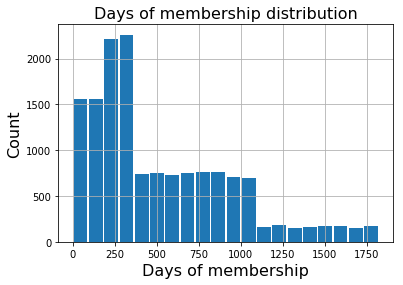

In [22]:
# distribution of new variable "days_of_membership"
profile_preproc['days_of_membership'].hist(bins=20, rwidth=0.9)
plt.xlabel('Days of membership', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Days of membership distribution', fontsize=16)

In [23]:
# check missing values --> None (good)
profile_preproc.isnull().sum()

age                   0
person                0
income                0
gender_F              0
gender_M              0
gender_O              0
days_of_membership    0
dtype: int64

## 2.3 Preprocess transcript DF

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
def clean_transcript(df):
    """
    extract important information from "value" column
    
    """
    
    # list for all keys from dictionary from "value" column
    value_keys = []
    
    # amount of rows
    n = df.shape[0]
    
    # find all keys
    for i in range(n):
        value_keys += df.loc[i, 'value'].keys()
    
    # find all unique keys
    unique_value_keys = np.unique(value_keys)
    print(unique_value_keys)
    
    # 4 different unique keys are found whereof 2 are the same ("offer_id" is the same as "offer id")
    offer_ids = np.repeat(None, n)
    
    # add to arrays
    for i in range(n):
        if 'offer id' in df.loc[i, 'value'].keys():
            offer_ids[i] = df.loc[i, 'value']['offer id']
        if 'offer_id' in df.loc[i, 'value'].keys():
            offer_ids[i] = df.loc[i, 'value']['offer_id']
    
    # add to df
    df['offer_id'] = offer_ids
    
    # no need for "amount" because we are not going to consider "transaction". 
    # "Transaction" are the only rows that contain values in "amount" 
    
    # "reward" not needed as it is part of portfolio df already
    
    # drop original column
    df.drop(columns='value', inplace=True)
    
    # sort by person and time
    df = df.sort_values(by=['person', 'time'])
    
    return df
    

In [26]:
transcript_preproc = clean_transcript(transcript.copy())
transcript_preproc.head(10)

['amount' 'offer id' 'offer_id' 'reward']


,event,person,time,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d
168412,transaction,0009655768c64bdeb2e877511632db8f,414,None
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4


## 2.4 Overview of preprocessed df's

In [27]:
portfolio_preproc

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [28]:
profile_preproc.head()

,age,person,income,gender_F,gender_M,gender_O,days_of_membership
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,376
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,443
2,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,91
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,167
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,257


In [29]:
transcript_preproc.head()

,event,person,time,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed


## 2.5 merge all 3 df's

In [30]:
# merge all 3 df's to obtain all information in one df
transcript_portfolio_df = transcript_preproc.merge(portfolio_preproc, on='offer_id', how='inner')
full_df = profile_preproc.merge(transcript_portfolio_df, on='person', how='inner')

# sort by person and time
full_df = full_df.sort_values(by=['person', 'time'])

print(full_df.shape)
full_df.head()

(148805, 18)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
32822,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,0,1,1,1,0
32823,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,0,1,1,1,0
32824,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,336,3f207df678b143eea3cee63160fa8bed,0,96,informational,0,1,1,0,1
32825,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0,96,informational,0,1,1,0,1
32826,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1


## 2.6 Business question

The order in which the events happen is critical to the definition of successful offers.

There are several groups of possible scenarios:
    
#### Group 1: people that are influenced by the offer
* offer_received --> offer_viewed --> offer_completed

#### Group 2: people that do not care for the offer
* offer_received --> offer_viewed

#### Group 3: people that receive an offer, but take no action
* offer_received

#### Group 4: people that buy products regardless of an offer
* all other orders (e.g. offer_received --> offer_completed)

Our focus lies on group 1 (responded to offer) and group 2 (does not respond to offer).
Group 3 doesn't yield much information. 
Group 4 buys products regardless of an offer which means they should not receive offers (from a business perspective).

We are going to assign labels to person-offer_id combinations in groups 1 and 2.

We want to answer the following business question:

## What attributes have the highest influence on a person's choice to respond to a certain Starbucks offer?

For this purpose we are going to build a machine learning model to predict if people are affectable by certain offers.

### Approach:
* a) Find out which person-offer_type combinations fall in group 1
* b) Find out which person-offer_type combinations fall in group 2
* c) Assign labels to either group
* d) Check if observations from group 1 actually responded to the offer within the duration of the offer (otherwise we assume they did not care for the offer and therefore belong to group 2)
* e) Once all labels were assigned, we are going to use a machine-learning model to predict if people respond to an offer or not
* f) Eventually we extract the feature importance from the best model that we could find

### remove event="transaction" and offer_type="informational" because we are not interested in this type of information

In [31]:
# # merge all 3 df's to obtain all information in one df
# transcript_portfolio_df = transcript_preproc.merge(portfolio_preproc, on='offer_id', how='inner')
# full_df = profile_preproc.merge(transcript_portfolio_df, on='person', how='inner')

# combination of "offer completed" and "informational" does not exist --> remove thos observations
print('amount of observations where "event = offer completed" and "offer_type = informational"')
print(len(full_df[(full_df['event'] == 'offer completed') & (full_df['offer_type'] == 'informational')]))
print('We remove "informational" because it does not fit to "offer completed"')

# we are going to omit "transaction" and focus on "offer completed"
full_df = full_df[full_df['event'] != 'transaction']

# remove offer type "informational" because it does not correspond to any "offer completed"
full_df = full_df[full_df['offer_type'] != 'informational']

# sort by person and time
full_df = full_df.sort_values(by=['person', 'time'])

full_df.head()

amount of observations where "event = offer completed" and "offer_type = informational"
0
We remove "informational" because it does not fit to "offer completed"


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
32826,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1
32827,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1
32828,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1
32829,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1
32830,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1


In [32]:
# ~ 126.000 transactional observations and no missing values
print(full_df.shape)
full_df.isnull().sum()

(126145, 18)


age                   0
person                0
income                0
gender_F              0
gender_M              0
gender_O              0
days_of_membership    0
event                 0
time                  0
offer_id              0
difficulty            0
duration              0
offer_type            0
reward                0
channel_email         0
channel_mobile        0
channel_social        0
channel_web           0
dtype: int64

## 2.7 assign group labels

### mark observations where offer was completed after it was viewed

In [33]:
# select all observations that include "offer viewed" and "offer completed"
offer_completed_after_viewed = full_df[(full_df['event']=='offer viewed') | (full_df['event']=='offer completed')].copy()

# add column with offer_id from previous column using pandas shift() function
offer_completed_after_viewed['pre_offer_id'] = offer_completed_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# assign label if offer was completed after it was viewed
offer_completed_after_viewed['offer_completed_after_viewed'] = np.where((offer_completed_after_viewed['pre_offer_id']==
                                                                         offer_completed_after_viewed['offer_id']) & 
                                                                        (offer_completed_after_viewed['event']==
                                                                         'offer completed'),1,0)
offer_completed_after_viewed.drop(columns='pre_offer_id', inplace=True)

offer_completed_after_viewed.head(10)

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
32827,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32828,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32830,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32831,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,540,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32833,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,576,2906b810c7d4411798c6938adc9daaa5,10,168,discount,2,1,1,0,1,0
36520,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,0
36521,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,1
36523,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36526,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,0,1,0
36524,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,1


### merge back "offer received"

In [34]:
# select all "offer received" observations 
offer_received = full_df[full_df['event']=='offer received']

# fill with nan 
offer_received['offer_completed_after_viewed']=np.nan

# append "offer_completed_after_viewed", fill NaN with 0 and sort by person and time
full_df_modified = offer_received.append(offer_completed_after_viewed, sort=False).fillna(0).sort_values(by=['person','time'])
full_df_modified['offer_completed_after_viewed'] = full_df_modified['offer_completed_after_viewed'] .astype(int)

print(full_df_modified.shape)
full_df_modified.head(12)

(126145, 19)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
32826,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32827,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32828,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32829,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32830,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32831,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,540,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32832,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,576,2906b810c7d4411798c6938adc9daaa5,10,168,discount,2,1,1,0,1,0
32833,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,576,2906b810c7d4411798c6938adc9daaa5,10,168,discount,2,1,1,0,1,0
36519,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,0
36520,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,0


### check ratio of "offer_completed" observations to all possible observations 

In [35]:
cust_offer_completed_after_viewed = full_df_modified[['person','offer_id']][(full_df_modified['offer_completed_after_viewed']==1)].groupby(['person','offer_id']).count().reset_index().shape[0]

all_cust_and_offers = full_df_modified[['person','offer_id']].groupby(['person','offer_id']).count().reset_index().shape[0]

print('ratio of offers that were completed after having been viewed: {}'.format(np.round(cust_offer_completed_after_viewed/all_cust_and_offers, 4)))


ratio of offers that were completed after having been viewed: 0.4715


### Comment
We have a more or less evenly distributed dataset regarding "offer completed" and "offer not completed" after it was viewed (~47/53%)

In [36]:
print(full_df_modified.shape)
print(len(np.unique(full_df_modified['person'])))

(126145, 19)
14764


### Group 1

In [37]:
# find all person-offer_id combinations where "offer_completed_after_viewed==1"
group1 = full_df_modified[['person','offer_id']][(full_df_modified['offer_completed_after_viewed']==1)].groupby(['person','offer_id']).count().reset_index()
print('{} person-offer_id combinations that contain "offer_completed_after_viewed"'.format(group1.shape[0]))
group1.head()

20830 person-offer_id combinations that contain "offer_completed_after_viewed"


,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4


In [38]:
# check --> look about right
full_df_modified[(full_df_modified['person'] == '0011e0d4e6b944f998e987f904e8c1e5') & 
                 (full_df_modified['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
36522,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36523,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36524,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,1


In the table above we notice the correct order of events to call this a "successful offer" (person responded to the offer).
However we still need to check if the order was completed within the offers' time.

### Group 2

In [39]:
# find unique person-offer_id pairs that contain "offers completed" 
contains_offer_completed = full_df_modified[['person','offer_id']][full_df_modified['event']=='offer completed'].groupby(['person','offer_id']).count().reset_index()

# find unique person-offer_id pairs that contain "offers received" 
contains_offer_received = full_df_modified[['person','offer_id']][full_df_modified['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# create merged dataset to diffrentiate groups
merged_df = contains_offer_completed.merge(contains_offer_received, how='right', on=['person','offer_id'], indicator=True)

# find observations that contain 'offer received' and "offer viewed" but not "offer completed"
group2 = merged_df[merged_df['_merge'] == 'right_only']
group2 = group2.merge(full_df_modified, how='left', on=['person','offer_id'])
group2 = group2[['person','offer_id']][group2['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
print('{} person-offer_id combinations that only contain observations of the form "offer received --> offer viewed"'.format(group2.shape[0]))
group2.head()

10952 person-offer_id combinations that only contain observations of the form "offer received --> offer viewed"


,person,offer_id
0,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd
1,00857b24b13f4fe0ad17b605f00357f5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,00857b24b13f4fe0ad17b605f00357f5,ae264e3637204a6fb9bb56bc8210ddfd
3,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d
4,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0


In [40]:
# check --> looks about right
full_df_modified[(full_df_modified['person'] == '005500a7188546ff8a767329a2f7c76a') & 
                 (full_df_modified['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
114626,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114627,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,60,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114628,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,168,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114629,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,186,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114630,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,576,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114631,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,576,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0


### check if group1 and group2 are distinct

In [41]:
# group1 and group 2 seem to be distinct as they have no common person-offer_id combination
group1.merge(group2, on=['person', 'offer_id'], how='inner')

,person,offer_id


In [42]:
group1.shape

(20830, 2)

In [43]:
group2.shape

(10952, 2)

In [44]:
# amount of rows that we should expect when appending both groups to 1 df
group1.shape[0]+group2.shape[0]

31782

Group2 displays events of the form "unsuccessful offer" because the offers were received and viewed but not completed.

### add group labels and append to obtain 1 df

In [45]:
# add group labels
group1['group1'] = 1
group2['group1'] = 0

In [46]:
# append both groups to 1 df
person_offer_group_df = group1.append(group2, sort=False)
print(person_offer_group_df.shape)
person_offer_group_df.head()

(31782, 3)


,person,offer_id,group1
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1


In [47]:
# check
full_df_modified[(full_df_modified['person'] == '0011e0d4e6b944f998e987f904e8c1e5') & 
                 (full_df_modified['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
36522,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36523,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36524,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,1


In [48]:
# check
person_offer_group_df[person_offer_group_df['group1']==0].head()

,person,offer_id,group1
0,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,0
1,00857b24b13f4fe0ad17b605f00357f5,4d5c57ea9a6940dd891ad53e9dbe8da0,0
2,00857b24b13f4fe0ad17b605f00357f5,ae264e3637204a6fb9bb56bc8210ddfd,0
3,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d,0
4,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [49]:
# check
full_df_modified[(full_df_modified['person'] == '005500a7188546ff8a767329a2f7c76a') & 
                 (full_df_modified['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
114626,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114627,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,60,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114628,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,168,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114629,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,186,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114630,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer received,576,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0
114631,56,005500a7188546ff8a767329a2f7c76a,47000.0,0,1,0,229,offer viewed,576,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,1,1,0,0


The dataframe "person_offer_group_df" should now only contain observations that belong to group1 (successful offer) or group2 (unsuccessful offer)

### Check if offer was completed within duration of offer

In [50]:
full_df_modified.head()

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
32826,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32827,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32828,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,1,1,1,0
32829,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0
32830,33,0009655768c64bdeb2e877511632db8f,72000.0,0,1,0,461,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0


In [51]:
# right merge "person_offer_group_df" to "full_df_modified" to obtain only relevant observations for our purpose
group1_2 = full_df_modified.merge(person_offer_group_df, on=['person', 'offer_id'], how='right')
group1_2 = group1_2.sort_values(by=['person', 'time'])
print(group1_2.shape)
group1_2.head(10)

(102427, 20)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed,group1
0,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,0,1
1,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,0,1
2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,discount,3,1,1,1,1,1,1
3,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0,1
4,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0,1
6,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,0,1,0,1
7,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,0,1,0,1
5,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,1,1
8,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,0,1,1,1
9,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,10,240,discount,2,1,1,1,1,0,1


In [52]:
# calculate time difference between "offer received" and "offer completed"
group1_2['time_diff_rec_compl'] = group1_2[(group1_2['event']=='offer received') | (group1_2['event']=='offer completed')].groupby(['person','offer_id'])['time'].diff(periods=1) 
group1_2.head(10)

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,...,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed,group1,time_diff_rec_compl
0,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,...,168,discount,3,1,1,1,1,0,1,NaN
1,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,...,168,discount,3,1,1,1,1,0,1,NaN
2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,...,168,discount,3,1,1,1,1,1,1,84.0
3,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,240,discount,5,1,0,0,1,0,1,NaN
4,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,240,discount,5,1,0,0,1,0,1,NaN
6,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,168,bogo,5,1,1,0,1,0,1,NaN
7,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,168,bogo,5,1,1,0,1,0,1,NaN
5,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,240,discount,5,1,0,0,1,1,1,168.0
8,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,168,bogo,5,1,1,0,1,1,1,72.0
9,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,...,240,discount,2,1,1,1,1,0,1,NaN


In [53]:
# check if time difference from "offer received" to "offer completed" is less or equal to "duration".
# If yes, then this was a valid offer. If no, we can assume, the customer did not care for the offer.
group1_2['valid_duration'] = 1*(group1_2['time_diff_rec_compl'] <= group1_2['duration'])
print(group1_2.shape)
group1_2.head(8)
# group1_2.loc[9:17, :]

(102427, 22)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,...,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed,group1,time_diff_rec_compl,valid_duration
0,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,...,discount,3,1,1,1,1,0,1,NaN,0
1,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,...,discount,3,1,1,1,1,0,1,NaN,0
2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,...,discount,3,1,1,1,1,1,1,84.0,1
3,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5,1,0,0,1,0,1,NaN,0
4,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5,1,0,0,1,0,1,NaN,0
6,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,5,1,1,0,1,0,1,NaN,0
7,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,5,1,1,0,1,0,1,NaN,0
5,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5,1,0,0,1,1,1,168.0,1


### Intermediate result
Now, we can really differentiate between people in group 1 and 2.
* Observations where "offer_completed_after_viewed==1" and "valid_duration==1" are people from group 1.
* Observations where "offer_completed_after_viewed==1" and "valid_duration==0" are people from group 2 because the seem not to care for the offer.
* Observations where "offer_completed_after_viewed==0" are also people from group 2 because they did not complete an offer after they saw it.


In [54]:
# add column with "valid_offer". 
# A value of 1 is set if the offer was completed after it was seen and within valid duration
# A value of 0 is set otherwise
group1_2['responded_to_offer']=np.where(((group1_2['offer_completed_after_viewed']==1) &
                                         (group1_2['valid_duration']==1)),1,0)
print(group1_2.shape)
group1_2.loc[26:31, :]

(102427, 23)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,...,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed,group1,time_diff_rec_compl,valid_duration,responded_to_offer
26,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,0,1,NaN,0,0
27,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer viewed,300,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,0,1,NaN,0,0
28,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer completed,384,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,1,1,216.0,1,1
29,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer received,408,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,0,1,24.0,1,0
30,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer viewed,420,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,0,1,NaN,0,0
31,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,offer completed,504,fafdcd668e3743c1bb461111dcafc2a4,...,2,1,1,1,1,1,1,96.0,1,1


### group by person and offer_id and add final label "responded to offer"

In [55]:
# group 1
responded_to_offer = group1_2[['person','offer_id']][group1_2['responded_to_offer']==1].groupby(['person','offer_id']).count().reset_index()
print(responded_to_offer.shape)
responded_to_offer.head()

(20830, 2)


,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4


In [56]:
# check
full_df_modified[(full_df_modified['person'] == '0011e0d4e6b944f998e987f904e8c1e5') & 
                 (full_df_modified['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
36522,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36523,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,0
36524,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,discount,5,1,0,0,1,1


In [57]:
# group 2 as difference between all person-offer_id combinations and group1
not_responded_to_offer = pd.concat([group1_2[['person','offer_id']].groupby(['person','offer_id']).count().reset_index(), responded_to_offer]).drop_duplicates(subset=['person','offer_id'], keep=False)
print(not_responded_to_offer.shape)

# not_responded_to_offer['offer_received_count'] = offer_received_count
not_responded_to_offer.head()

(10952, 2)


,person,offer_id
14,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd
20,00857b24b13f4fe0ad17b605f00357f5,4d5c57ea9a6940dd891ad53e9dbe8da0
21,00857b24b13f4fe0ad17b605f00357f5,ae264e3637204a6fb9bb56bc8210ddfd
22,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d
23,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0


In [58]:
# check
full_df_modified[(full_df_modified['person'] == '00857b24b13f4fe0ad17b605f00357f5') & 
                 (full_df_modified['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed
117252,71,00857b24b13f4fe0ad17b605f00357f5,41000.0,0,1,0,276,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,bogo,10,1,1,1,1,0
117253,71,00857b24b13f4fe0ad17b605f00357f5,41000.0,0,1,0,276,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,bogo,10,1,1,1,1,0


In [59]:
# add labels
responded_to_offer['responded_to_offer'] = 1
not_responded_to_offer['responded_to_offer'] = 0

In [60]:
# append 
grouped_df = responded_to_offer.append(not_responded_to_offer, sort=False)
grouped_df.head()

,person,offer_id,responded_to_offer
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1


In [61]:
group1_2[(group1_2['person'] == '0011e0d4e6b944f998e987f904e8c1e5') &
        (group1_2['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')]

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,event,time,offer_id,...,reward,channel_email,channel_mobile,channel_social,channel_web,offer_completed_after_viewed,group1,time_diff_rec_compl,valid_duration,responded_to_offer
3,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5,1,0,0,1,0,1,NaN,0,0
4,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5,1,0,0,1,0,1,NaN,0,0
5,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5,1,0,0,1,1,1,168.0,1,1


### merge back to portfolio_preproc and profile_preproc

In [62]:
# create final df containing all relevant information
final_df = profile_preproc.merge(grouped_df, on=['person'], how='inner', sort=False)
final_df = final_df.merge(portfolio_preproc, on=['offer_id'], how='inner', sort=False)
final_df = final_df.sort_values(by=['person', 'offer_id'])
print(final_df.shape)
final_df.head()

(31782, 17)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,offer_id,responded_to_offer,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
30329,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,20,240,discount,5,1,0,0,1
21165,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,2298d6c36e964ae4a3e7e9706d1fb8c2,1,7,168,discount,3,1,1,1,1
643,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,168,bogo,5,1,1,0,1
25614,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,4d5c57ea9a6940dd891ad53e9dbe8da0,1,10,120,bogo,10,1,1,1,1
8120,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,fafdcd668e3743c1bb461111dcafc2a4,1,10,240,discount,2,1,1,1,1


In [63]:
final_df.groupby(['responded_to_offer']).count()['person']

responded_to_offer
0    10952
1    20830
Name: person, dtype: int64

In [64]:
final_df.describe()

,age,income,gender_F,gender_M,gender_O,days_of_membership,responded_to_offer,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web
count,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.000000,31782.0,31782.000000,31782.000000,31782.000000
mean,54.506922,65530.237241,0.411176,0.573469,0.015355,522.959568,0.655402,8.953968,169.002077,5.459851,1.0,0.938770,0.766377,0.856397
std,17.180569,21175.699729,0.492055,0.494581,0.122961,421.676911,0.475244,3.520359,43.041365,3.181890,0.0,0.239755,0.423142,0.350693
min,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,120.000000,2.000000,1.0,0.000000,0.000000,0.000000
25%,43.000000,50000.000000,0.000000,0.000000,0.000000,206.000000,0.000000,7.000000,120.000000,3.000000,1.0,1.000000,1.000000,1.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,356.000000,1.000000,10.000000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,800.000000,1.000000,10.000000,168.000000,10.000000,1.0,1.000000,1.000000,1.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,1823.000000,1.000000,20.000000,240.000000,10.000000,1.0,1.000000,1.000000,1.000000


### Comment
* We notice that "channel_email" always contains a value of 1 which makes this variable useless since it does not have any variation at all. 
We are going to remove this variable.
* About 2/3 of all person-offer_id combinations have the label "responded_to_offer=1" and the remaining 1/3 has the label "responded_to_offer=0".
Therefor, the machine learning model might predict a positive response with more accuracy than a positive response.

In [65]:
final_df.drop(columns=['channel_email'], inplace=True)
final_df.head()

,age,person,income,gender_F,gender_M,gender_O,days_of_membership,offer_id,responded_to_offer,difficulty,duration,offer_type,reward,channel_mobile,channel_social,channel_web
30329,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,20,240,discount,5,0,0,1
21165,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,2298d6c36e964ae4a3e7e9706d1fb8c2,1,7,168,discount,3,1,1,1
643,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,168,bogo,5,1,0,1
25614,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,4d5c57ea9a6940dd891ad53e9dbe8da0,1,10,120,bogo,10,1,1,1
8120,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,fafdcd668e3743c1bb461111dcafc2a4,1,10,240,discount,2,1,1,1


## 2.8 split data into bogo and discount and do some final preprocessing steps

We are going two create 2 machine-learning models, 1 for "bogo" and one for "discount"

In [66]:
np.unique(final_df['offer_type'])

array(['bogo', 'discount'], dtype=object)

### bogo

In [67]:
bogo_df = final_df[final_df['offer_type']=='bogo']
bogo_df.drop(columns=['offer_type'], inplace=True)
print(bogo_df.shape)
bogo_df.head()

(17146, 15)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,offer_id,responded_to_offer,difficulty,duration,reward,channel_mobile,channel_social,channel_web
643,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,168,5,1,0,1
25614,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,4d5c57ea9a6940dd891ad53e9dbe8da0,1,10,120,10,1,1,1
1348,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,1,0,0,622,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,168,5,1,0,1
17458,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,1,0,0,622,f19421c1d4aa40978ebb69ca19b0e20d,1,5,120,5,1,1,1
16396,55,004b041fbfe44859945daa2c7f79ee64,74000.0,1,0,0,79,f19421c1d4aa40978ebb69ca19b0e20d,1,5,120,5,1,1,1


In [68]:
bogo_df[['gender_F', 'gender_M', 'gender_O', 'responded_to_offer']].mean()

gender_F              0.407617
gender_M              0.577861
gender_O              0.014522
responded_to_offer    0.580427
dtype: float64

### comment
* More or less equal distribution of "responded_to_offer" (58% to 42%).
* Gender is highly unbalanced due to "gender=Other".

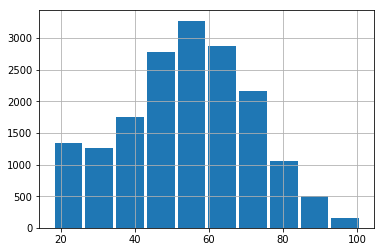

In [69]:
bogo_df['age'].hist(rwidth=0.9)

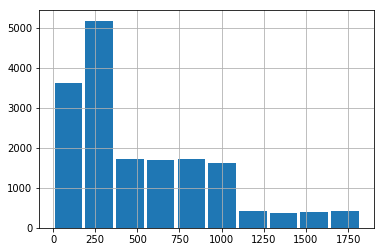

In [70]:
bogo_df['days_of_membership'].hist(rwidth=0.9)

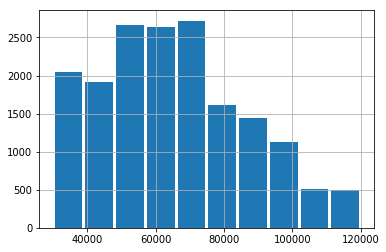

In [71]:
bogo_df['income'].hist(rwidth=0.9)

### discount

In [72]:
discount_df = final_df[final_df['offer_type']=='discount']
discount_df.drop(columns='offer_type', inplace=True)
print(discount_df.shape)
discount_df.head()

(14636, 15)


,age,person,income,gender_F,gender_M,gender_O,days_of_membership,offer_id,responded_to_offer,difficulty,duration,reward,channel_mobile,channel_social,channel_web
30329,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,20,240,5,0,0,1
21165,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0,0,1,198,2298d6c36e964ae4a3e7e9706d1fb8c2,1,7,168,3,1,1,1
8120,59,0020c2b971eb4e9188eac86d93036a77,90000.0,1,0,0,874,fafdcd668e3743c1bb461111dcafc2a4,1,10,240,2,1,1,1
22377,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,1,0,0,622,2298d6c36e964ae4a3e7e9706d1fb8c2,1,7,168,3,1,1,1
10349,26,003d66b6608740288d6cc97a6903f4f0,73000.0,1,0,0,400,fafdcd668e3743c1bb461111dcafc2a4,1,10,240,2,1,1,1


In [73]:
discount_df[['gender_F', 'gender_M', 'gender_O', 'responded_to_offer']].mean()

gender_F              0.415346
gender_M              0.568325
gender_O              0.016330
responded_to_offer    0.743236
dtype: float64

### comment
* distribution of "responded_to_offer" (74% to 26%) more imbalanced compared to bogo.
* Gender  seems to have a similar distribution as for bogo.

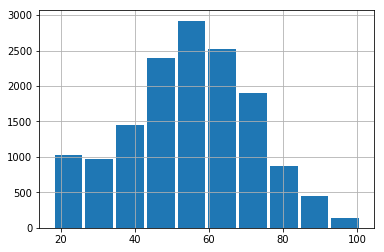

In [74]:
discount_df['age'].hist(rwidth=0.9)

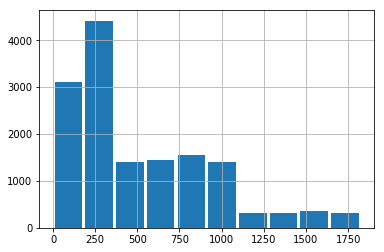

In [75]:
discount_df['days_of_membership'].hist(rwidth=0.9)

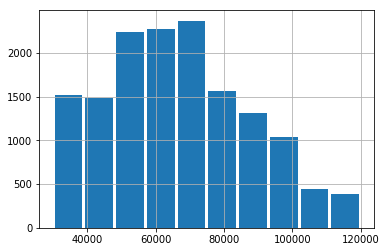

In [76]:
discount_df['income'].hist(rwidth=0.9)

# 3 Modelling
We are going to build 2 models - 1 for bogo and 1 for discount - and display the influence of each variable to the response.

In [77]:
def find_X_y(df):
    """
    select predictors and response variable from df
    
    """
    
    X = df[['age', 'income', 'gender_F', 'gender_M', 'gender_O', 'days_of_membership', 'difficulty', 'duration',
            'reward', 'channel_mobile', 'channel_social', 'channel_web']]
    y = df['responded_to_offer']
    
    return X,y
    

def split_and_scale_model(X, y):
    """
    split data into training/test set and scale data with StandardScaler. 
    
    """
    
    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # scaler
    scaler = MinMaxScaler()
    
    # scale training data
    X_train = scaler.fit_transform(X_train)
    
    # scale test data
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test


def train_model_and_predict(model, X_train, X_test, y_train):
    """
    train model and make predictions for X_test
    
    """
    
    # fit model
    model = model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    return model, y_pred
    
    
def score_model(y_test, y_pred):
    """
    print classification report
    
    """
    
    print(classification_report(y_test, y_pred))
    

### Bogo

In [78]:
# select bogo data
X_bogo, y_bogo = find_X_y(bogo_df)

# split data
X_train_bogo, X_test_bogo, y_train_bogo, y_test_bogo = split_and_scale_model(X_bogo, y_bogo)

# initialize classifier
model_bogo = RandomForestClassifier()

# train and predict 
model_bogo, y_pred_bogo = train_model_and_predict(model_bogo, X_train_bogo, X_test_bogo, y_train_bogo)
score_model(y_test_bogo, y_pred_bogo)
confusion_matrix(y_test_bogo, y_pred_bogo)

             precision    recall  f1-score   support

          0       0.63      0.67      0.65      1466
          1       0.74      0.70      0.72      1964

avg / total       0.69      0.69      0.69      3430



array([[ 986,  480],
       [ 590, 1374]])

### Bogo fine-tuning

In [79]:
def fine_tuning(X, y):
    """
    Optimise classifier parameters
    
    """
    
    # parameters for grid search
    params={'max_depth' : [5, 10, 20],
            'n_estimators': [50, 100, 200],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10, 20],
            }
    
    # optimise
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), params)
    
    # fit
    grid_search.fit(X, y)
    
    # select best params
    grid_search.best_params_
    return grid_search.best_params_


def plot_feature_importance(model, cols):
    """
    plot feature importances
    
    """
    
    feature_importances = pd.DataFrame(model.feature_importances_,index = cols, 
                                       columns=['importance']).sort_values('importance',ascending=False)
    feature_importances.plot.bar()
    plt.title('Feature importance')
    plt.show()

In [80]:
%%time
# fine tuning with GridSearch
fine_tuning(X_train_bogo, y_train_bogo)

CPU times: user 5min 52s, sys: 185 ms, total: 5min 52s
Wall time: 5min 54s


{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [81]:
# run with optimised parameters
model_bogo = RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=200)
model_bogo, y_pred_bogo = train_model_and_predict(model_bogo, X_train_bogo, X_test_bogo, y_train_bogo)
score_model(y_test_bogo, y_pred_bogo)
confusion_matrix(y_test_bogo, y_pred_bogo)

             precision    recall  f1-score   support

          0       0.73      0.59      0.65      1466
          1       0.73      0.84      0.78      1964

avg / total       0.73      0.73      0.73      3430



array([[ 859,  607],
       [ 314, 1650]])

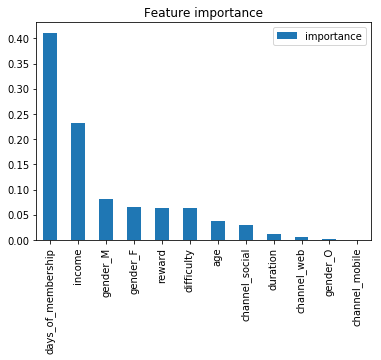

In [82]:
# plot feature importance
plot_feature_importance(model_bogo, X_bogo.columns)

### Discount

In [83]:
# select discount data
X_discount, y_discount = find_X_y(discount_df)

# split data
X_train_discount, X_test_discount, y_train_discount, y_test_discount = split_and_scale_model(X_discount, y_discount)

# initialize classifier
model_discount = RandomForestClassifier()

# train and predict model
model_discount, y_pred_discount = train_model_and_predict(model_discount, X_train_discount, X_test_discount, y_train_discount)
score_model(y_test_discount, y_pred_discount)
confusion_matrix(y_test_discount, y_pred_discount)

             precision    recall  f1-score   support

          0       0.45      0.44      0.44       737
          1       0.81      0.82      0.82      2191

avg / total       0.72      0.72      0.72      2928



array([[ 323,  414],
       [ 392, 1799]])

### Discount fine-tuning

In [84]:
%%time
# fine tuning
fine_tuning(X_train_discount, y_train_discount)

CPU times: user 4min 53s, sys: 80.1 ms, total: 4min 53s
Wall time: 4min 54s


{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [85]:
# run with optimised parameters
model_discount = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=100)
model_discount, y_pred_discount = train_model_and_predict(model_discount, X_train_discount, X_test_discount, y_train_discount)
score_model(y_test_discount, y_pred_discount)
confusion_matrix(y_test_discount, y_pred_discount)

             precision    recall  f1-score   support

          0       0.54      0.26      0.35       737
          1       0.79      0.93      0.85      2191

avg / total       0.73      0.76      0.73      2928



array([[ 189,  548],
       [ 158, 2033]])

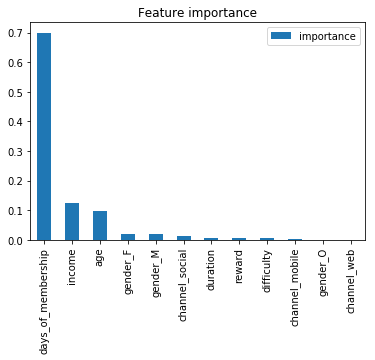

In [86]:
# plot feature importance
plot_feature_importance(model_discount, X_discount.columns)

# 4. Conclusion

Bogo-model:

After fine-tuning the model, we come to an f1-score of 0.72 which is not bad but not great.
The model seems to predict positive case (responded to offer) better than the negative case (did not respond to offer).
This should not be surprising as we have many more positive responses in the dataset.

The attributes that have by far the most influence on the outcome are "days_of_membership" and "income". 
It hardly matters on what channel the offer is sent or what the duration of the offer is. 


Discount-model:
    
After fine-tuning the model, we come to an f1-score of 0.73 (similar as to bogo-model).
This model seems to predict positive cases (responded to offer) a lot better than negative cases (did not respond to offer).
This should again not be surprising as we have many more positive responses in the dataset.
However, this should not be a problem because sending offers to people who will not use them anyways is not as bad 
as not sending offers to people, who would have made a purchase only if they had had an offer.

The attributes that have the most influence on the outcome are "days_of_membership", "income" and "age". 
The remaining attributes seem to have very little influence on the response. 


Remarks:

On the one hand, we could certainly do better (see 4.1. Comments and outlook),
on the other hand it can also be difficult to predict human behaviour because it does not always
follow a clear pattern or structure. 
People with a similar time of membership, income and age might react differently to the same offer.
Therefor, it is probably impossible to find a model that is almost perfect.

# 4.1 Comments and outlook

* Mabye other models (e.g. logistic regression) would yield better results.
* We could also try to group the age variable (e.g. young adults/adults/seniors) and the income variable (e.g. low/medium/high income). 
Maybe this would help.
* Another possibility could be changing the response to $$\frac{\text{amount of completed offer}}{\text{amount of received offers}}$$ and run a regression model on this response.

As we can see there are several other possibilities that could be tested to try to find a better model.
Personally, I think any of the suggestions would might be helpful, but as I am running out of time, I will not be able to try any of them.
Feel free to build up on these ideas.

